In [1]:
pip install pandas


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install sklearn

  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
   

In [3]:
!pip install pyarrow


In [34]:
import mlflow 
mlflow.set_tracking_uri('sqlite:///mlflow.db --port 5001')
mlflow.set_experiment("nyc-taxi-experiment")

2026/01/16 19:17:45 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/16 19:17:45 INFO mlflow.store.db.utils: Updating database tables
2026/01/16 19:17:45 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/16 19:17:45 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/16 19:17:45 INFO alembic.runtime.migration: Running upgrade  -> 451aebb31d03, add metric step
2026/01/16 19:17:45 INFO alembic.runtime.migration: Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
2026/01/16 19:17:45 INFO alembic.runtime.migration: Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
2026/01/16 19:17:45 INFO alembic.runtime.migration: Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
2026/01/16 19:17:45 INFO alembic.runtime.migration: Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
2026/01/16 19:17:45 INFO alembic.runtime.migration: Running 

<Experiment: artifact_location='/workspaces/MLops/experiment_tracking/mlruns/1', creation_time=1768591065871, experiment_id='1', last_update_time=1768591065871, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [3]:
import pandas as pd

In [4]:
import pickle

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:

!wget https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2025-01.parquet


--2026-01-16 19:01:24--  https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2025-01.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 3.165.247.79, 3.165.247.72, 3.165.247.187, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|3.165.247.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1178451 (1.1M) [binary/octet-stream]
Saving to: ‘green_tripdata_2025-01.parquet’

green_tripdata_2025 100%[===================>]   1.12M  1.88MB/s    in 0.6s    

2026-01-16 19:01:25 (1.88 MB/s) - ‘green_tripdata_2025-01.parquet’ saved [1178451/1178451]



In [35]:
df = pd.read_parquet('green_tripdata_2025-01.parquet')

df['duration'] = (df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']).dt.total_seconds() / 60

df = df[(df['duration'] >= 1) & (df['duration'] <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

print(f"Shape after cleaning: {df.shape}")
print("Duration stats:", df['duration'].describe())



Shape after cleaning: (46307, 22)
Duration stats: count    46307.000000
mean        13.493045
std          8.627705
min          1.000000
25%          7.550000
50%         11.450000
75%         16.983333
max         60.000000
Name: duration, dtype: float64


In [36]:
import numpy as np

In [37]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

X= df.drop('duration', axis=1)  
y = df['duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
        ('num', 'passthrough', numerical)
    ])

model = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),  # ✅ FIXED
        ('num', 'passthrough', numerical)
    ])),
    ('ridge', Ridge())
])
model = Pipeline([
    ('prep', ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
        ('num', 'passthrough', numerical)
    ])),
    ('ridge', Ridge())
])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


RMSE: 6.85351688214287


In [38]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred)

44.947378437909876

/tmp/ipykernel_38409/2857391098.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')


/tmp/ipykernel_38409/2857391098.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


<Axes: ylabel='Density'>

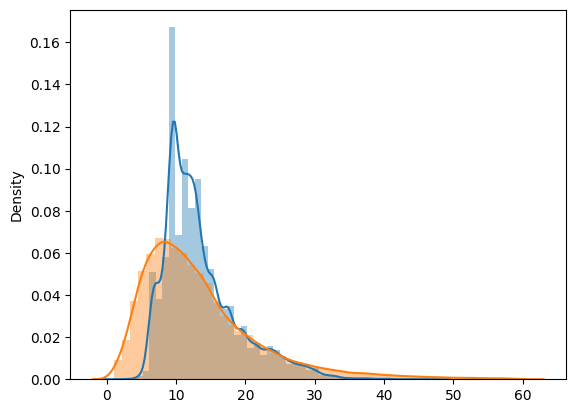

In [39]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')


In [40]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [22]:
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet   

--2026-01-16 19:08:16--  https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 3.165.247.163, 3.165.247.79, 3.165.247.72, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|3.165.247.163|:443... 

connected.
HTTP request sent, awaiting response... 200 OK
Length: 1333519 (1.3M) [binary/octet-stream]
Saving to: ‘green_tripdata_2021-01.parquet’

green_tripdata_2021 100%[===================>]   1.27M  2.03MB/s    in 0.6s    

2026-01-16 19:08:17 (2.03 MB/s) - ‘green_tripdata_2021-01.parquet’ saved [1333519/1333519]

--2026-01-16 19:08:17--  https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 3.165.247.187, 3.165.247.163, 3.165.247.79, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|3.165.247.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1145679 (1.1M) [binary/octet-stream]
Saving to: ‘green_tripdata_2021-02.parquet’

green_tripdata_2021 100%[===================>]   1.09M  1.86MB/s    in 0.6s    

2026-01-16 19:08:18 (1.86 MB/s) - ‘green_tripdata_2021-02.parquet’ saved [1145679/1145679]



In [41]:
df_train = read_dataframe('green_tripdata_2021-01.parquet')
df_val = read_dataframe('green_tripdata_2021-02.parquet')

In [42]:
len(df_train), len(df_val)

(73908, 61921)

In [43]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [44]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [45]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [46]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred)

60.19766166037688

In [47]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [48]:
import os
import pickle


os.makedirs('models', exist_ok=True)

with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)


In [49]:
with mlflow.start_run():
 mlflow.set_tag("developer","Tom")
 mlflow.log_param("train_data_path","green_tridata_2025-01.csv")
 mlflow.log_param("valid_data_path","green_tridata_2025-02.csv")
 alpha=0.01 
 mlflow.log_param("alpha",alpha)   
 lr = Lasso(alpha)
 lr.fit(X_train, y_train)

 y_pred = lr.predict(X_val)

 rmse=mean_squared_error(y_val, y_pred)
 mlflow.log_metric("rmse",rmse)